In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### 30 minutes agg.

In [2]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_30T', 
    freq=30,
    normalize_time=True
    )

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.20, 0.23) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

### Create, Train, and Perform Inference

In [ ]:
for kernel in covar_combinations:
    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_30T', 
    freq=30,
    normalize_time=True)
    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        time_agg='30T',
        training_iter=100,
        lr=0.1,
        machine='gesamtmessung',
        update_score=True
    )

In [ ]:
mse, mape

Iter 1 , Loss = 0.9814834846286535 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.9474980924054397 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.9145772187456217 , Noise = 0.5982218384742737
Iter 4 , Loss = 0.8823601691552403 , Noise = 0.5543984174728394
Iter 5 , Loss = 0.8505572859888687 , Noise = 0.5129923224449158
Iter 6 , Loss = 0.8190452877974886 , Noise = 0.47396120429039
Iter 7 , Loss = 0.787901268767308 , Noise = 0.437256395816803
Iter 8 , Loss = 0.757336253211181 , Noise = 0.40282461047172546
Iter 9 , Loss = 0.7275753012437843 , Noise = 0.3706086575984955
Iter 10 , Loss = 0.6987742784257162 , Noise = 0.34054747223854065
Iter 11 , Loss = 0.6710037369753405 , Noise = 0.31257545948028564
Iter 12 , Loss = 0.6442704011216341 , Noise = 0.2866224944591522
Iter 13 , Loss = 0.6185440227834563 , Noise = 0.2626136839389801
Iter 14 , Loss = 0.5937697287443402 , Noise = 0.2404693067073822
Iter 15 , Loss = 0.5698559496808465 , Noise = 0.22010475397109985
Iter 16 , Loss = 0.5466500510644735

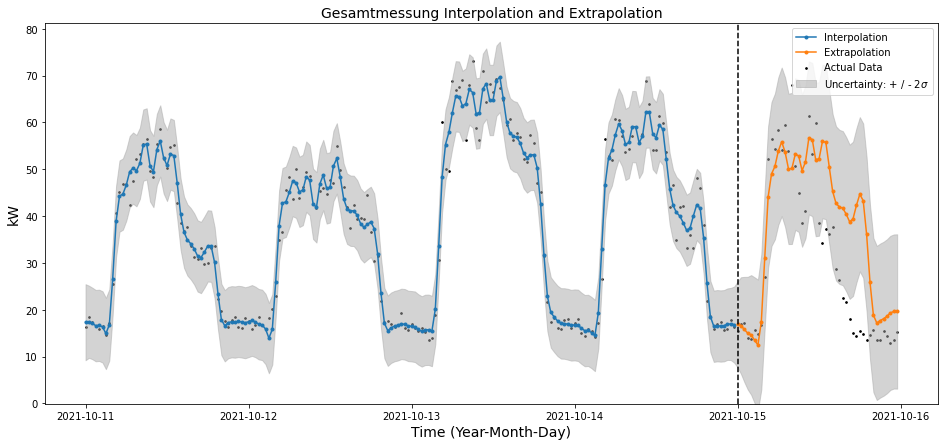

                 time     actual        machine
0 2021-10-13 04:30:00  60.024934  Gesamtmessung
1 2021-10-14 04:30:00  56.487998  Gesamtmessung


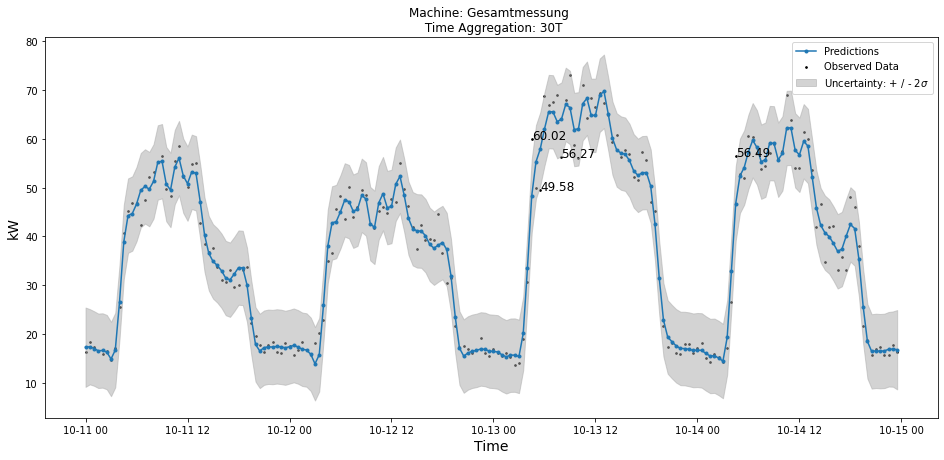

    index                time        machine control_limit  actual_kw  \
0       0 2021-10-15 08:00:00  Gesamtmessung         upper  67.989351   
1       0 2021-10-15 12:30:00  Gesamtmessung         lower  34.241928   
2       1 2021-10-15 13:00:00  Gesamtmessung         lower  37.139723   
3       2 2021-10-15 15:30:00  Gesamtmessung         lower  22.564209   
4       3 2021-10-15 16:00:00  Gesamtmessung         lower  21.551631   
5       4 2021-10-15 16:30:00  Gesamtmessung         lower  18.026375   
6       5 2021-10-15 17:00:00  Gesamtmessung         lower  15.102880   
7       6 2021-10-15 17:30:00  Gesamtmessung         lower  14.387217   
8       7 2021-10-15 18:00:00  Gesamtmessung         lower  15.374839   
9       8 2021-10-15 18:30:00  Gesamtmessung         lower  14.774898   
10      9 2021-10-15 19:00:00  Gesamtmessung         lower  13.422571   

    expected_kw      bound  
0     50.154993  66.281945  
1     55.931769  39.519151  
2     55.742607  39.317817  
3     4

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:522: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:523: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:531: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[1].scatter(orig_time[c

IndexError: index 192 is out of bounds for axis 0 with size 192

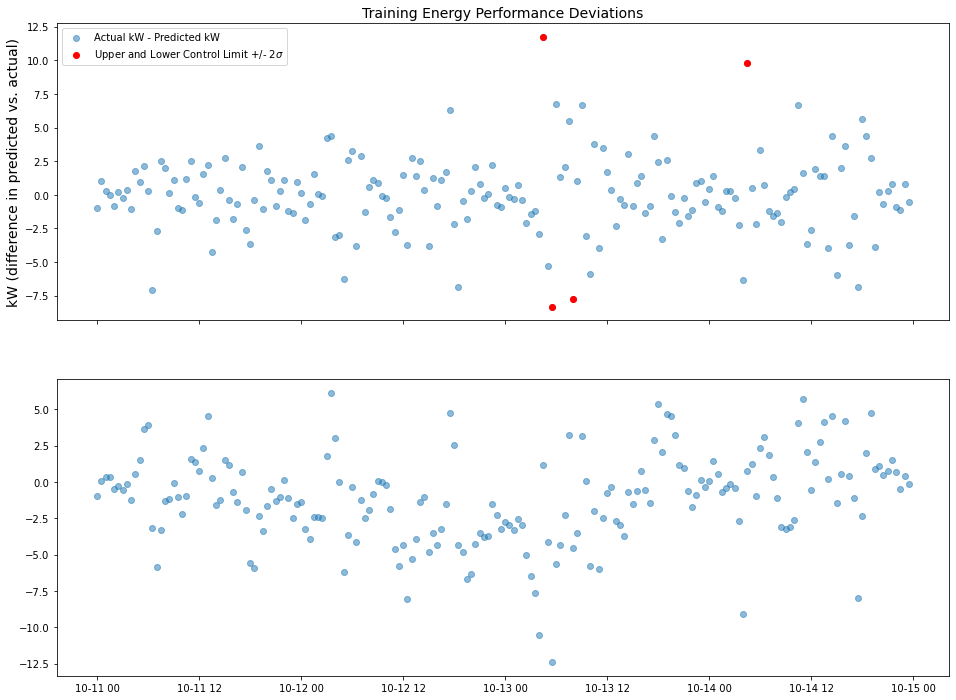

In [4]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module6,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='30T',
    training_iter=100,
    lr=0.1,
    machine='Gesamtmessung',
    update_score=False
)

In [ ]:
import numpy as np
np.sqrt(mse)

In [ ]:
mse, mape

### 10 minutes agg.

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_10T', 
    freq=10,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.19, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

In [ ]:
for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_10T', 
    freq=10,
    normalize_time=True
    )
    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        training_iter=75,
        lr=0.1,
        time_agg='10T',
        machine='gesamtmessung',
        update_score=True
    )

In [ ]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module1,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='10T',
    machine='gesamtmessung',
    update_score=False)

In [ ]:
np.sqrt(mse)

In [ ]:
mse, mape

### 5 minutes

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_5T', 
    freq=5,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.19, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

In [ ]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=75,
    lr=0.05,
    time_agg='5T',
    machine='Gesamtmessung',
    update_score=False
)